In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('full-data-acoustic-logger-leakage-challenge-january-update.xlsx', engine='openpyxl')

Finding the most common pipe diameters.
Pipe diameter calculations to see common pipe diameters so that the robot can be the right size

<ipython-input-15-7bd9d00e7bf3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pipe_diameters['PipeAllmm'] = np.where(pipe_diameters["Units"] == 'In',pipe_diameters['Diameter']*25.4,pipe_diameters['Diameter'])


(0.0, 300.0)

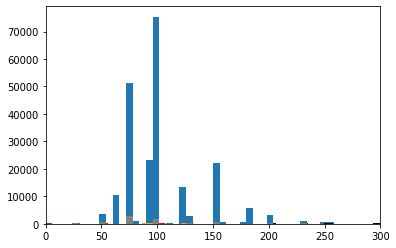

In [15]:
## create new df with only relevant columns
pipe_diameters = data[["Diameter","Units", "pipeType"]]
## convert from inches to mm where the unit column is inches
pipe_diameters['PipeAllmm'] = np.where(pipe_diameters["Units"] == 'In',pipe_diameters['Diameter']*25.4,pipe_diameters['Diameter'])
## find max pipe diameter to create better graphs
## outlier is a raw water main that transports water from source to treatment facility - can be ignored for this project
max_pipe_diameter = pipe_diameters['PipeAllmm'].max()
max_pipe_diameter_index = pipe_diameters['PipeAllmm'].idxmax()
## remove raw water mains as these are of no interest to us - we are focused on post treatment distribution
# pipe_diameters = pipe_diameters[pipe_diameters.pipeType != "Raw Water Main"] ##leave this in for now
# max_pipe_diameter = pipe_diameters['PipeAllmm'].max()
# max_pipe_diameter_index = pipe_diameters['PipeAllmm'].idxmax()
#### Separate by pipe types - two main types trunk and distribution , others are washout, private, proposed, abandoned, raw

distribution_diameters = pipe_diameters[pipe_diameters.pipeType == "Distribution Main"]
trunk_diameters = pipe_diameters[pipe_diameters.pipeType == "Trunk Main"]
raw_water_diameters = pipe_diameters[pipe_diameters.pipeType == "Raw Water Main"]
washout_diameters = pipe_diameters[pipe_diameters.pipeType == "Washout Main - Potab"]
private_diameters = pipe_diameters[pipe_diameters.pipeType == "Private Main"]
proposed_diameters = pipe_diameters[pipe_diameters.pipeType == "Proposed Main"]
abandoned_diameters = pipe_diameters[pipe_diameters.pipeType == "Abandoned Main"]

## create histogram
#comment all but one to see individually

plt.hist(distribution_diameters['PipeAllmm'], bins=100)
plt.hist(trunk_diameters['PipeAllmm'],color='black', bins=100)
plt.hist(washout_diameters['PipeAllmm'],color='green')
plt.hist(private_diameters['PipeAllmm'], color ='red', bins = 100)
plt.hist(proposed_diameters['PipeAllmm'], color='orange')
plt.hist(abandoned_diameters['PipeAllmm'],color='grey', bins=100)
plt.hist(raw_water_diameters['PipeAllmm'],color='pink')

plt.xlim([0,300])

Looking at pipe age and material

18.909451692051075

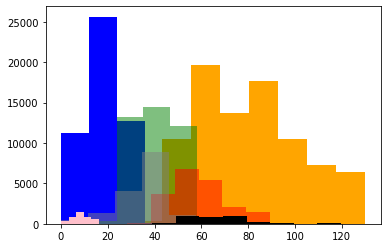

In [34]:
## create a new df with necessary columns

pipe_material_age = data[["Material", "Age_of_Pipe"]]

## see unique materials and count their values

# clearly iron is the main material with cast being the biggest and then 
# other forms of iron also accounting for another 8 or so percent
# print(pipe_material_age["Material"].unique())
unique_material_counts = pipe_material_age["Material"].value_counts(normalize=True)

## Pipe age stuff


#plt.hist(pipe_material_age["Age_of_Pipe"])

# abandoned_diameters = pipe_diameters[pipe_diameters.pipeType == "Abandoned Main"]

plt.hist(pipe_material_age[pipe_material_age.Material == 'Cast Iron']["Age_of_Pipe"],color='orange')
plt.hist(pipe_material_age[pipe_material_age.Material == 'Polyethylene']["Age_of_Pipe"],color='blue')
plt.hist(pipe_material_age[pipe_material_age.Material == 'PVC']["Age_of_Pipe"],alpha=0.5,color='green')
plt.hist(pipe_material_age[pipe_material_age.Material == 'Asbestos Cement']["Age_of_Pipe"],alpha=0.5,color='red')
plt.hist(pipe_material_age[pipe_material_age.Material == 'Ductile Iron']["Age_of_Pipe"],alpha=0.5,color='grey')
plt.hist(pipe_material_age[pipe_material_age.Material == 'Protectaline']["Age_of_Pipe"],alpha=1,color='pink')
plt.hist(pipe_material_age[pipe_material_age.Material == 'Spun Iron']["Age_of_Pipe"],alpha=1,color='black')


pipe_material_age[pipe_material_age.Material == 'Cast Iron']["Age_of_Pipe"].mean()
pipe_material_age[pipe_material_age.Material == 'Polyethylene']["Age_of_Pipe"].mean()

Looking at leaks and where they are most likely to occur in terms of pipe diameters, ages, materials, type, etc etc

- definitely have average leak flow
- note on total leaks found and false positives - 40% FP according to Wessex Water



1.0850325203641604


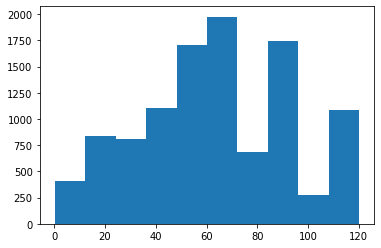

In [17]:
### create df with necessary data for leaks - will grow

leak_data = data[["Leakage Saving (m3/hr)", "Result", "Age_of_Pipe", "leakScore", "Type_of_PO", "dbMin", "pipeType", "Material"]]
## replace whitespace with nan
leak_data = leak_data.replace(r'^\s*$', np.nan, regex=True)

## average leak loss 
# plt.hist(leak_data['Leakage Saving (m3/hr)'],bins=50)
print(leak_data.loc[:, 'Leakage Saving (m3/hr)'].mean())
leak_data.loc[:, 'Leakage Saving (m3/hr)'].std()

## success rate of 60% with POI that leakage inspectors were sent to investigate
unique_leak_investigation_results = leak_data["Result"].value_counts(normalize=False)

### leak score by pipe age
### drop rows without POI's
leak_data_only_POI = leak_data[leak_data['Type_of_PO'].notna()] #Result for ones that were investigated, Type_of_PO for ones that were only flagged
# plt.scatter(leak_data_only_POI["Age_of_Pipe"], leak_data_only_POI["leakScore"])

### ages of pipes where leaks were investigated/flagged
plt.hist(leak_data_only_POI["Age_of_Pipe"])
type_pipe_where_leaks_were_investigated_flagged = leak_data_only_POI["Material"].value_counts(normalize=True)



In [13]:
##### Decision Tree/Random Forest - see what makes the most sense -> Flagged Y/N / Investigated Y/N / Leak Found Y/N

flag_or_inv = "Type_of_PO"   ## Result or Type_of_PO

#### Prepare dataset with necessary cols
tree_df = data[["Diameter","Units", "pipeType","Material", "Age_of_Pipe", flag_or_inv]] # Again Type_of_PO or Result or narrow further into Result
## replace whitespace with nan
tree_df = tree_df.replace(r'^\s*$', np.nan, regex=True)
## convert from inches to mm where the unit column is inches
tree_df['PipeAllmm'] = np.where(tree_df["Units"] == 'In',tree_df['Diameter']*25.4,tree_df['Diameter'])

#### Dataset is very imbalanced (many more rows without POI's raised than without)
#### Balance dataset by undersampling the negative cases (no POI's raised)
# print(len(tree_df), " rows in entire dataset")
num_flagged_rows = len(tree_df[tree_df[flag_or_inv].notna()])

## all cases where something is flagged
flag_pos = tree_df[tree_df[flag_or_inv].notna()]
## cases where nothing is flagged (column value is NaN), downsample to number of flag 
flag_neg = tree_df[tree_df[flag_or_inv].isna()].sample(num_flagged_rows)

## join sets back together
flag_both = pd.concat((flag_pos, flag_neg))



### fill nan so that we can compare against nan values
flag_both[flag_or_inv] = flag_both[flag_or_inv].fillna('nan')
### binarise from flag present or NaN value to 1 and 0 respectively
flag_both[flag_or_inv+"_binary"] = (flag_both[flag_or_inv] != 'nan').astype(int)

### binarise categorical variables
flag_both = pd.get_dummies(flag_both, columns=['pipeType'])
flag_both = pd.get_dummies(flag_both, columns=['Material'])


## find the mean and std of this so it is easier to present in slide
print('mean', flag_both['Age_of_Pipe'].mean(), 'std', flag_both['Age_of_Pipe'].std())
### normalise continuous variables
flag_both['Age_of_Pipe'] = (flag_both['Age_of_Pipe']-flag_both['Age_of_Pipe'].mean())/flag_both['Age_of_Pipe'].std()



flag_both['PipeAllmm'] = (flag_both['PipeAllmm']-flag_both['PipeAllmm'].mean())/flag_both['PipeAllmm'].std()


### remove unwanted columns - we have replaced diameter and units with PipeAllmm
flag_both = flag_both.drop(columns=['Diameter', 'Units', flag_or_inv])

flag_both = flag_both.dropna()



mean 57.939153695666306 std 30.144725375108525


In [7]:
### start with sklearn
from sklearn.model_selection import train_test_split

#split into train validate test, 0.5,0.25,0.25
ttrain, other = train_test_split(flag_both, test_size=0.7, random_state=None)

ttvalidation, ttest = train_test_split(other, test_size=0.5, random_state=None)


#create the X and y by dropping or keeping columns
X_train = ttrain.drop(columns=[flag_or_inv+"_binary"])
y_train = ttrain[flag_or_inv+"_binary"]

X_val = ttvalidation.drop(columns=[flag_or_inv+"_binary"])
y_val = ttvalidation[flag_or_inv+"_binary"]

X_test = ttest.drop(columns=[flag_or_inv+"_binary"])
y_test = ttest[flag_or_inv+"_binary"]


In [8]:
############ Decision Tree
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import tree

clf1 = tree.DecisionTreeClassifier(max_depth=2, min_impurity_decrease=0.0001)
clf1.fit(X_train,y_train)
print('Accuracy on the val set: {}'.format(accuracy_score(y_val, clf1.predict(X_val))))

clf2 = tree.DecisionTreeClassifier(max_depth=3, min_impurity_decrease=0.01)
clf2.fit(X_train,y_train)
print('Accuracy on the val set: {}'.format(accuracy_score(y_val, clf2.predict(X_val))))

clf3 = tree.DecisionTreeClassifier(max_depth=3, min_impurity_decrease=0.05)
clf3.fit(X_train,y_train)
print('Accuracy on the val set: {}'.format(accuracy_score(y_val, clf3.predict(X_val))))

best_model = clf2
print('Accuracy on the test set: {}'.format(accuracy_score(y_test, best_model.predict(X_test))))
print('Recall on the test set: {}'.format(recall_score(y_test, best_model.predict(X_test))))
print('Precision on the test set: {}'.format(precision_score(y_test, best_model.predict(X_test))))

Accuracy on the val set: 0.6084529505582137
Accuracy on the val set: 0.6065922381711856
Accuracy on the val set: 0.49800637958532695
Accuracy on the test set: 0.6018604651162791
Recall on the test set: 0.6481381543443065
Precision on the test set: 0.5867122618466047


In [9]:
####### Looking at feature importance
feature_importance = pd.DataFrame(clf1.feature_importances_, index=X_train.columns).sort_values(0,ascending=False)
feature_importance

,0
Age_of_Pipe,0.822653
Material_Cast Iron,0.124335
pipeType_Distribution Main,0.053012
Material_Grey Iron,0.000000
Material_Steel,0.000000
Material_Spun Iron,0.000000
Material_Protectaline,0.000000
Material_Polyethylene,0.000000
Material_Plastic/Polythene,0.000000
Material_PVC,0.000000


In [10]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=4, min_samples_split=4)
model = model.fit(X_train, y_train)
ypred = model.predict(X_val)
acc = accuracy_score(y_val, ypred)
print(acc)

0.6109782030834663


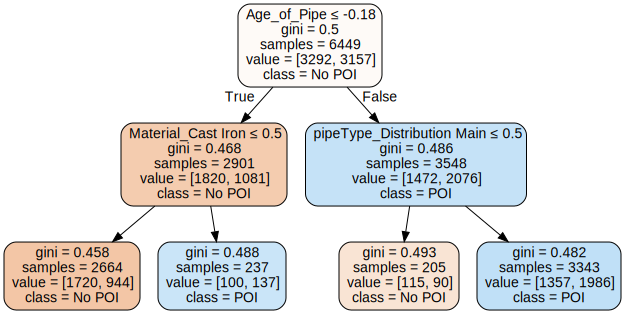

In [11]:
######## Visualise the decision tree/random forest

import sklearn.tree as tree
import graphviz
dot_data = tree.export_graphviz(clf1, out_file=None) 
graph = graphviz.Source(dot_data) 

predictors = X_train.columns
dot_data = tree.export_graphviz(clf1, out_file=None,
                                feature_names = predictors,
                                class_names = ('No POI', 'POI'),
                                filled = True, rounded = True,
                                special_characters = True)
graph = graphviz.Source(dot_data)  
graph 